
# <center>Кому на Руси помогать хорошо: Парсим НКО при помощи Python</center>
<img src="http://apptractor.ru/wp-content/uploads/2014/03/charities-header.png" height="200" width="200"> 


---

<h3 style="text-align: right;" markdown="1">Дмитрий Сергеев</h3>

## Импортируем необходимые библиотеки

In [24]:
from urllib.request import urlopen, Request # написание обращений к сайту, открытие ссылок
import re                                   # регулярные выражения, для поиска/очистки строк 

from bs4 import BeautifulSoup               # красивый суп для преобразования html-мусора 
                                            # в структурированное дерево

import time                                 # будем использовать для ограничения числа запросов в секунду

import pandas as pd
import numpy as np

Генерация фейкового юзер-агента, чтобы быть похожим на человека - https://pypi.python.org/pypi/user_agent

In [26]:
import sys
sys.path.append('/Users/dmitrys/anaconda2/lib/python2.7/site-packages')
from user_agent import generate_user_agent

In [27]:
generate_user_agent()

'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/43.0.2388.56 Safari/537.36'

In [29]:
generate_user_agent()

'Mozilla/5.0 (X11; Linux i686 on x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2688.18 Safari/537.36'

###  Наша главная ссылка, по которой мы будем в дальнейшем гулять, добавляя новые значения для страницы, а также ссылка для благотворительной организации

In [ ]:
http://ivsezaodnogo.ru/foundations?search_by=name
http://ivsezaodnogo.ru/foundations/458

In [31]:
main_url = "http://ivsezaodnogo.ru/foundations?search_by=name&page={}"
sub_url = "http://ivsezaodnogo.ru/foundations/{}"

Если в ссылку подставить число - получим валидный url, на который можно перейти

In [32]:
main_url.format(5)

'http://ivsezaodnogo.ru/foundations?search_by=name&page=5'

Попробуем перейти и посмотреть

In [34]:
{"User-Agent":generate_user_agent()}

{'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_8) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/44.0.2435.95 Safari/537.36'}

In [33]:
req = Request('http://ivsezaodnogo.ru/foundations?search_by=name&page=5', headers={"User-Agent":generate_user_agent()})
webpage = urlopen(req).read()
print(webpage[0:200])

b"<!DOCTYPE html>\n<html lang='ru-RU'>\n<head>\n<meta charset='utf-8'>\n<title>\n\xd0\xa1\xd0\xbf\xd1\x80\xd0\xb0\xd0\xb2\xd0\xbe\xd1\x87\xd0\xbd\xd0\xb8\xd0\xba \xd0\xb1\xd0\xbb\xd0\xb0\xd0\xb3\xd0\xbe\xd1\x82\xd0\xb2\xd0\xbe\xd1\x80\xd0\xb8\xd1\x82\xd0\xb5\xd0\xbb\xd1\x8c\xd0\xbd\xd1\x8b\xd1\x85 \xd0\xbe\xd1\x80\xd0\xb3\xd0\xb0\xd0\xbd\xd0\xb8\xd0\xb7\xd0\xb0\xd1\x86\xd0\xb8\xd0\xb9 / \xd0\x98 \xd0\xb2\xd1\x81\xd0\xb5 \xd0\xb7\xd0\xb0 \xd0\xbe\xd0\xb4\xd0\xbd\xd0\xbe\xd0\xb3\xd0\xbe\n</title>\n<meta co"


In [35]:
soup = BeautifulSoup(webpage, "lxml")

In [36]:
print(soup)

<!DOCTYPE html>
<html lang="ru-RU">
<head>
<meta charset="utf-8"/>
<title>
Справочник благотворительных организаций / И все за одного
</title>
<meta content="Благотворительные организации в Москве, подробный список организаций, социальные организации. Наша цель – помочь людям, оказавшимся в беде. Наш телефон в Москве: +7 (968) 419-99-90" name="description"/>
<meta content="" name="keywords"/>
<meta content="5f1c28a92cbde15a" name="yandex-verification"/>
<meta content="Справочник благотворительных организаций / И все за одного" property="og:title"/>
<meta content="Благотворительные организации в Москве, подробный список организаций, социальные организации. Наша цель – помочь людям, оказавшимся в беде. Наш телефон в Москве: +7 (968) 419-99-90" property="og:description"/>
<meta content="http://ivsezaodnogo.ru/images/og_logo.png" property="og:image"/>
<link href="http://ivsezaodnogo.ru/images/og_logo.png" rel="image_src"/>
<link href="/images/favicon_128.png" rel="shortcut icon" type="imag

## А теперь вытащим с текущей страницы все url, ведущие на страницы НКО

In [37]:
urls_block = soup.find('div', attrs={'class':'js-lazy-loader b-foundations-list'}).findAll('a', attrs={'class':'link'})

In [38]:
urls_block[0:3]

[<a class="link" href="/foundations/452" title="Подсолнух"><span class="name">Подсолнух</span>
 </a>,
 <a class="link" href="/foundations/150" title="Помоги.Орг"><span class="name">Помоги.Орг</span>
 </a>,
 <a class="link" href="/foundations/560" title='Православная служба помощи "Милосердие"'><span class="name">Православная служба помощи "Милосердие"</span>
 </a>]

Отсюда нужно вытащить только цифры, так как у нас уже есть формат ссылки для перехода на страницу НКО. Воспользуемся регулярными выражениями!

In [39]:
nko_urls = re.findall(r'\d+', str(urls_block))
nko_urls

['452',
 '150',
 '560',
 '526',
 '352',
 '425',
 '521',
 '596',
 '565',
 '446',
 '622',
 '154',
 '623',
 '447',
 '517',
 '466']

Осталось собрать всё сделанное в красивую функцию, принимающую на вход номер страницы и возвращающу список ссылок

In [40]:
def getUrls(page):
    req = Request(main_url.format(page), headers={'User-Agent': generate_user_agent()})
    webpage = urlopen(req).read()
    soup = BeautifulSoup(webpage, "lxml")
    urls_block = soup.find('div', attrs={'class':'js-lazy-loader b-foundations-list'}).findAll('a', attrs={'class':'link'})
    nko_urls = re.findall(r'\d+', str(urls_block))
    return nko_urls

In [41]:
getUrls(5)

['452',
 '150',
 '560',
 '526',
 '352',
 '425',
 '521',
 '596',
 '565',
 '446',
 '622',
 '154',
 '623',
 '447',
 '517',
 '466']

In [42]:
def html_stripper(text):
    # очищает строку от всех html-тэгов
    return re.sub('<[^<]+?>', '', str(text))

## Теперь мы можем получить ссылки на все НКО, перечисленные на сайты, осталось научиться переходить на их страницы, чтобы оттуда всё достать

In [43]:
sub_url.format(452)

'http://ivsezaodnogo.ru/foundations/452'

In [44]:
def getPage(page):
    # Возвращает страницу с НКО
    req = Request(sub_url.format(page), headers={'User-Agent': generate_user_agent()})
    webpage = urlopen(req).read()
    soup = BeautifulSoup(webpage, "lxml")
    return soup

In [45]:
page = getPage(452)

In [46]:
str(page)[0:200]

'<!DOCTYPE html>\n<html lang="ru-RU">\n<head>\n<meta charset="utf-8"/>\n<title>\nБлаготворительный фонд "Фонд помощи детям с нарушениями иммунитета "Подсолнух" / И все за одного\n</title>\n<meta content="Благ'

In [47]:
organization_name = html_stripper(page.find("h1"))

In [48]:
organization_name

'Благотворительный фонд "Фонд помощи детям с нарушениями иммунитета "Подсолнух"'

In [49]:
information = page.find("div", attrs={'class':'groups'})
information = re.split("Решает проблемы|Кому оказывается помощь", str(information))
    

In [50]:
information

['<div class="groups">\n<div class="column float-right">\n<h3 class="sub-title">',
 '</h3>\n<div class="js-expandable">\n<div class="description-wrapper">\n<ul class="list description" data-height-from-children="4">\n<li class="bold">Лечение заболеваний</li>\n<li>Наследственные/генетические заболевания</li>\n<li>Редкие (орфанные) заболевания</li>\n</ul>\n</div>\n<div class="toggler-wrapper">\n<a class="dashed js-toggler more" href="javascript:;">показать все</a>\n<a class="dashed js-toggler rollup" href="javascript:;">свернуть ↑</a>\n</div>\n</div>\n</div>\n<div class="column float-left">\n<h3 class="sub-title">',
 '</h3>\n<ul class="list">\n<li>Ребенок (0-11 лет)</li>\n<li>Подросток (12-17 лет)</li>\n</ul>\n</div>\n</div>']

In [51]:
def getInformation(page):
    #### Organization name
    organization_name = html_stripper(page.find("h1"))
    
    information = page.find("div", attrs={'class':'groups'})
    information = re.split("Решает проблемы|Кому оказывается помощь", str(information))
    
    #### Problems
    problems_solving = html_stripper(information[1]).split('\n')
    problems_solving = [x for x in problems_solving if x] # удаляем пустые значения
    problems_solving = list(set(problems_solving)) # удаляем дубликаты
    problems_solving.remove("показать все")
    problems_solving.remove('свернуть ↑')
    
    #### Target audience
    audience = html_stripper(information[2]).split('\n')
    audience = [x for x in audience if x]
    
    #### Description
    description = html_stripper(page.find("div", attrs={"class":"description"}))
    
    return {'name':organization_name, 
            'problems_solving':problems_solving, 
            'audience':audience, 
            'description':description}

In [52]:
getInformation(page)

{'audience': ['Ребенок (0-11 лет)', 'Подросток (12-17 лет)'],
 'description': '\nОписание благотворительной организации\nБлаготворительный фонд "Фонд помощи детям с нарушениями иммунитета "Подсолнух" был создан в 2006 году усилиями неравнодушных людей и работает, чтобы спасти жизни младенцев и детей, больных врожденным иммунодефицитом и аутоиммунными заболеваниями.\nКому помогает фонд? \nСегодня мы помогаем находить средства на покупку дорогостоящих препаратов для лечения детей в возрасте до 18 лет, страдающих опасными для жизни заболеваниями иммунной системы:\n• первичный иммунодефицит;\n• тяжелая комбинированная иммунная недостаточность (ТКИН);\n• синдром Вискотта-Олдрича и др.\nОплата лечения происходит только по официальному запросу врачей по конкретной истории болезни. Денежные средства, поступающие на счета фонда, используются на лечение каждого ребенка только адресно.\nФонд проводит еженедельные творческие занятия с детьми, проходящими курс лечения в отделении иммунологии РДКБ и

## Координаты можно получить из яндекс карт

In [53]:
contacts = page.find("div", attrs={"class":"contacts js-donate-block"})
yandex_url = re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', str(contacts))[0]

In [54]:
yandex_url

'http://maps.yandex.ru/?text=119285,%20%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0,%20%D1%83%D0%BB.%20%D0%9F%D1%8B%D1%80%D1%8C%D0%B5%D0%B2%D0%B0,%20%D0%B4.%209,%20%D0%BA%D0%BE%D1%80%D0%BF.%202'

In [55]:
def getCoordinatesFromYandex(yandex_url):
    try:
        req = Request(yandex_url, headers={'User-Agent': generate_user_agent()})
        webpage = urlopen(req).read()
        soup = BeautifulSoup(webpage, "lxml")
        soup.find("div", attrs={"class":"toponym-card-view__coordinates-deg"})
        coordinates = re.split("coordinates", str(soup))[-2]
        coordinates = re.findall(r'\d+[\.]?\d*', coordinates)[0:2]
    except:
        coordinates=[np.NaN, np.NaN]
    return coordinates

In [56]:
getCoordinatesFromYandex(yandex_url)

['37.524201', '55.72709']

In [57]:
def getContacts(page):
    contacts = page.find("div", attrs={"class":"contacts js-donate-block"})
    yandex_url = re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', str(contacts))[0]
    
    longtitude, latitude = getCoordinatesFromYandex(yandex_url)
    
    address = html_stripper(contacts.find("a",attrs={'class':"info-line address"}))
    telephone = html_stripper(contacts.find("div", attrs={"class":"info-line phone"}))
    email = html_stripper(contacts.find("div", attrs={"class":"info-line email"}))
    website = html_stripper(contacts.find("div", attrs={"class":"info-line web"}))
    return {'longtitude':float(longtitude),
            "latitude":float(latitude), 
            'address':address, 
            'telephone':telephone, 
            'email':email, 
            'website':website}

In [58]:
getContacts(page)

{'address': '119285, Москва, ул. Пырьева, д. 9, корп. 2',
 'email': 'fond@fondpodsolnuh.ru',
 'latitude': 55.72709,
 'longtitude': 37.524201,
 'telephone': '8(495)767-73-38',
 'website': 'http://www.fondpodsolnuh.ru/'}

## Итак, все поля собраны, осталось пройтись по всем страницам поиска, чтобы собрать полный список ссылок и затем перейти на каждую из них

In [59]:
def getAllUrls(last_page=50):
    nko_urls = set()
    
    for i in range(1,last_page):
        urls = getUrls(i)
        time.sleep(0.3)
        if len(urls)!=0:
            nko_urls.update(urls)
        else:
            break
    nko_urls = list(nko_urls)
    return nko_urls

In [60]:
nko_urls = getAllUrls()

KeyboardInterrupt: 

In [ ]:
nko_urls[0:10]

In [ ]:
len(nko_urls)

Итого получили 511 ссылок на огранизации. Создадим датафрейм со всеми необходимыми полями

In [ ]:
FINAL = pd.DataFrame(columns=["name",
                             "address",
                             "longtitude",
                             "latitude",
                             "telephone",
                             "email",
                             "website",
                             "problems_solving", 
                             "audience", 
                             "description"])

In [ ]:
for number in nko_urls:
    time.sleep(0.3)            # ограничим число запросов 3 в секунду, чтобы не нагружать сайт
    page = getPage(number)     # выгружаем все данные со странички
    FINAL = FINAL.append({**getContacts(page), **getInformation(page)}, ignore_index=True)
    
FINAL.to_csv("/Users/dmitrys/Desktop/DataProjects/OpenDataNKO/FINAL.csv")

# А теперь посмотрим, что выгрузилось :)

In [61]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")
import pandas as pd

In [62]:
data = pd.read_csv("FINAL.csv")

In [63]:
data.shape

(511, 11)

In [64]:
data.head(2)

,Unnamed: 0,name,address,longtitude,latitude,telephone,email,website,problems_solving,audience,description
0,0,"Благотворительный фонд ""Фонд продовольствия ""Р...","127006, г. Москва, Старопименовский переулок, ...",37.604717,55.770097,8(495)212-14-92,info@foodbankrus.ru,http://foodbankrus.ru/,"['Социальная помощь', 'Помощь в тяжелой жизнен...","['Ребенок (0-11 лет)', 'Подросток (12-17 лет)'...",\nОписание благотворительной организации\n«Фон...
1,1,"Благотворительный фонд ""Помоги делом""","185035, Республика Карелия, Петрозаводск, ул. ...",34.374448,61.789228,8(906)208-80-80,fond@pomogi-delom.ru,http://pomogi-delom.ru/,['Неврологические и психоневрологические забол...,"['Ребенок (0-11 лет)', 'Подросток (12-17 лет)'...",\nОписание благотворительной организации\n28 д...


In [65]:
data.drop(["Unnamed: 0"], axis=1, inplace=True)

In [66]:
data.head(2)

,name,address,longtitude,latitude,telephone,email,website,problems_solving,audience,description
0,"Благотворительный фонд ""Фонд продовольствия ""Р...","127006, г. Москва, Старопименовский переулок, ...",37.604717,55.770097,8(495)212-14-92,info@foodbankrus.ru,http://foodbankrus.ru/,"['Социальная помощь', 'Помощь в тяжелой жизнен...","['Ребенок (0-11 лет)', 'Подросток (12-17 лет)'...",\nОписание благотворительной организации\n«Фон...
1,"Благотворительный фонд ""Помоги делом""","185035, Республика Карелия, Петрозаводск, ул. ...",34.374448,61.789228,8(906)208-80-80,fond@pomogi-delom.ru,http://pomogi-delom.ru/,['Неврологические и психоневрологические забол...,"['Ребенок (0-11 лет)', 'Подросток (12-17 лет)'...",\nОписание благотворительной организации\n28 д...


In [67]:
data.problems_solving.loc[0]

"['Социальная помощь', 'Помощь в тяжелой жизненной ситуации', 'Нефинансовая/гуманитарная помощь', 'Волонтерская помощь']"

In [68]:
import ast
# Преобразуем строковые колонки с листами в непосредственный тип листа
data.problems_solving = data.problems_solving.apply(ast.literal_eval)
data.audience = data.audience.apply(ast.literal_eval)

## Посмотрим на решаемые проблемы

In [69]:
data.problems_solving.apply(len).idxmax() # ищем организацию с максимальным списков решаемых проблем

273

In [70]:
data.loc[273]

name                 Международный благотворительный фонд "Дети мира"
address                  109004, Москва, Пестовский пер., д. 12, к. 1
longtitude                                                      37.66
latitude                                                       55.746
telephone                                             8(495)995-03-40
email                                               info@deti-mira.ru
website                                      http://www.deti-mira.ru/
problems_solving    [Психологическая помощь, Сахарный диабет, Конс...
audience            [Ребенок (0-11 лет), Подросток (12-17 лет), Си...
description         \nОписание благотворительной организации\nМежд...
Name: 273, dtype: object

In [71]:
columns = data.problems_solving.loc[data.problems_solving.apply(len).idxmax()]

In [72]:
for i in columns:
    print(i)

Психологическая помощь
Сахарный диабет
Консалтинг в области филантропии для социально ответственного бизнеса
Нужен донор
Социальная помощь
Лечение заболеваний
Правовая поддержка
Волонтерская помощь
Реабилитация и адаптация
Онкологические заболевания
Заболевания опорно-двигательного аппарата
Поддержка НКО
Наследственные/генетические заболевания
Нефинансовая/гуманитарная помощь
Паллиативная помощь
Неврологические и психоневрологические заболевания
Гематологические заболевания
Сердечно-сосудистые заболевания
Помощь в тяжелой жизненной ситуации
Зависимость
Редкие (орфанные) заболевания
Другие заболевания органов и систем (дыхания, пищеварения, слуха, зрения, мочеполовой системы, печени, кожи, инфекционные заболевания, ожоги, дефекты внешности)
СПИД/ВИЧ/Гепатит


In [73]:
def getProblems(row):
    # преобразовываем в несколько колонок решаемые проблемы
    encoded = []
    for i in columns:
        if i in data.problems_solving.loc[row]:
            encoded.append(True)
        else:
            encoded.append(False)
    return encoded

In [74]:
getProblems(0)

[False,
 False,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False]

In [75]:
problems = data.reset_index()['index'].apply(getProblems)
problems_data = pd.DataFrame(problems.tolist(), columns=columns)

In [77]:
# переименуем колонку, чтобы название было покороче
problems_data.rename(columns={"Другие заболевания органов и систем (дыхания, пищеварения, слуха, зрения, мочеполовой системы, печени, кожи, инфекционные заболевания, ожоги, дефекты внешности)":
                              "Другие заболевания органов и систем"}, inplace=True)

In [78]:
problems_data.head(2)

,Психологическая помощь,Сахарный диабет,Консалтинг в области филантропии для социально ответственного бизнеса,Нужен донор,Социальная помощь,Лечение заболеваний,Правовая поддержка,Волонтерская помощь,Реабилитация и адаптация,Онкологические заболевания,...,Нефинансовая/гуманитарная помощь,Паллиативная помощь,Неврологические и психоневрологические заболевания,Гематологические заболевания,Сердечно-сосудистые заболевания,Помощь в тяжелой жизненной ситуации,Зависимость,Редкие (орфанные) заболевания,Другие заболевания органов и систем,СПИД/ВИЧ/Гепатит
0,False,False,False,False,True,False,False,True,False,False,...,True,False,False,False,False,True,False,False,False,False
1,False,False,False,False,True,True,False,True,False,True,...,True,False,True,False,False,True,False,False,False,False


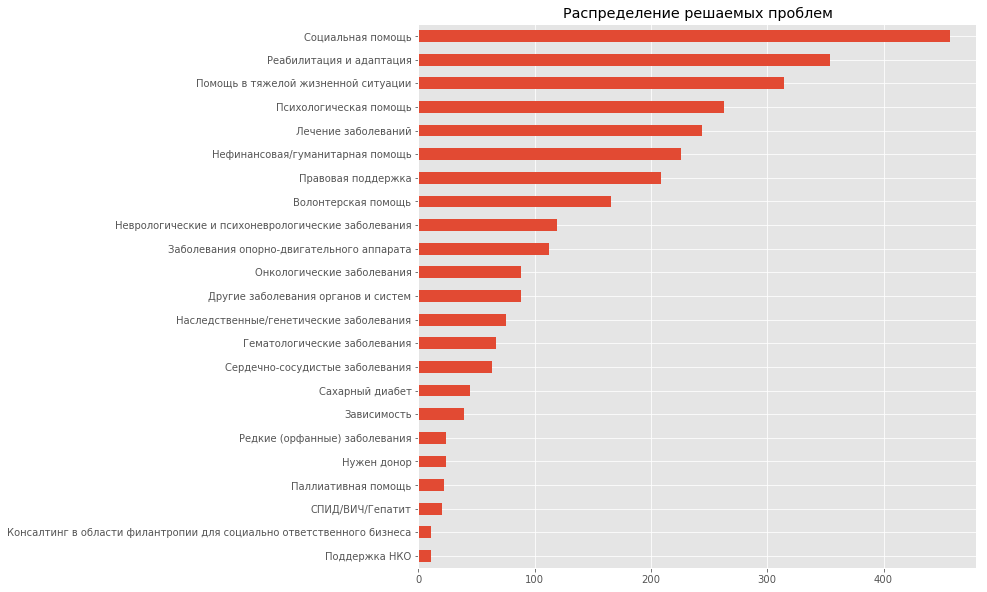

In [79]:
plt.figure(figsize=(10, 10))
problems_data.sum().sort_values().plot(kind="barh");
plt.title("Распределение решаемых проблем");

In [80]:
data = pd.concat([data, problems_data], axis=1)

In [81]:
data.head(2)

,name,address,longtitude,latitude,telephone,email,website,problems_solving,audience,description,...,Нефинансовая/гуманитарная помощь,Паллиативная помощь,Неврологические и психоневрологические заболевания,Гематологические заболевания,Сердечно-сосудистые заболевания,Помощь в тяжелой жизненной ситуации,Зависимость,Редкие (орфанные) заболевания,Другие заболевания органов и систем,СПИД/ВИЧ/Гепатит
0,"Благотворительный фонд ""Фонд продовольствия ""Р...","127006, г. Москва, Старопименовский переулок, ...",37.604717,55.770097,8(495)212-14-92,info@foodbankrus.ru,http://foodbankrus.ru/,"[Социальная помощь, Помощь в тяжелой жизненной...","[Ребенок (0-11 лет), Подросток (12-17 лет), Вз...",\nОписание благотворительной организации\n«Фон...,...,True,False,False,False,False,True,False,False,False,False
1,"Благотворительный фонд ""Помоги делом""","185035, Республика Карелия, Петрозаводск, ул. ...",34.374448,61.789228,8(906)208-80-80,fond@pomogi-delom.ru,http://pomogi-delom.ru/,[Неврологические и психоневрологические заболе...,"[Ребенок (0-11 лет), Подросток (12-17 лет), Вз...",\nОписание благотворительной организации\n28 д...,...,True,False,True,False,False,True,False,False,False,False


## Кому помогают

In [82]:
data.audience.apply(len).idxmax()

389

In [83]:
columns = data.audience.loc[data.audience.apply(len).idxmax()]

In [84]:
columns

['Ребенок (0-11 лет)',
 'Подросток (12-17 лет)',
 'Взрослый (18-59 лет)',
 'Пожилой (старше 60 лет)',
 'Инвалид',
 'Сирота',
 'Беженец/мигрант',
 'Малоимущий/безработный/многодетная семья',
 'Бездомный',
 'Военнослужащие/семьи погибших',
 'Заключенный/бывший заключенный',
 'Пострадавший от стихийных бедствий/катастроф/войн']

In [85]:
def getAudience(row):
    # преобразовываем в несколько колонок решаемые проблемы
    encoded = []
    for i in columns:
        if i in data.audience.loc[row]:
            encoded.append(True)
        else:
            encoded.append(False)
    return encoded

In [86]:
getAudience(0)

[True, True, True, True, True, False, True, True, True, False, False, True]

In [87]:
audience = data.reset_index()['index'].apply(getAudience)
audience_data = pd.DataFrame(audience.tolist(), columns=columns)

In [88]:
audience_data.head(2)

,Ребенок (0-11 лет),Подросток (12-17 лет),Взрослый (18-59 лет),Пожилой (старше 60 лет),Инвалид,Сирота,Беженец/мигрант,Малоимущий/безработный/многодетная семья,Бездомный,Военнослужащие/семьи погибших,Заключенный/бывший заключенный,Пострадавший от стихийных бедствий/катастроф/войн
0,True,True,True,True,True,False,True,True,True,False,False,True
1,True,True,True,False,True,False,False,True,False,False,False,False


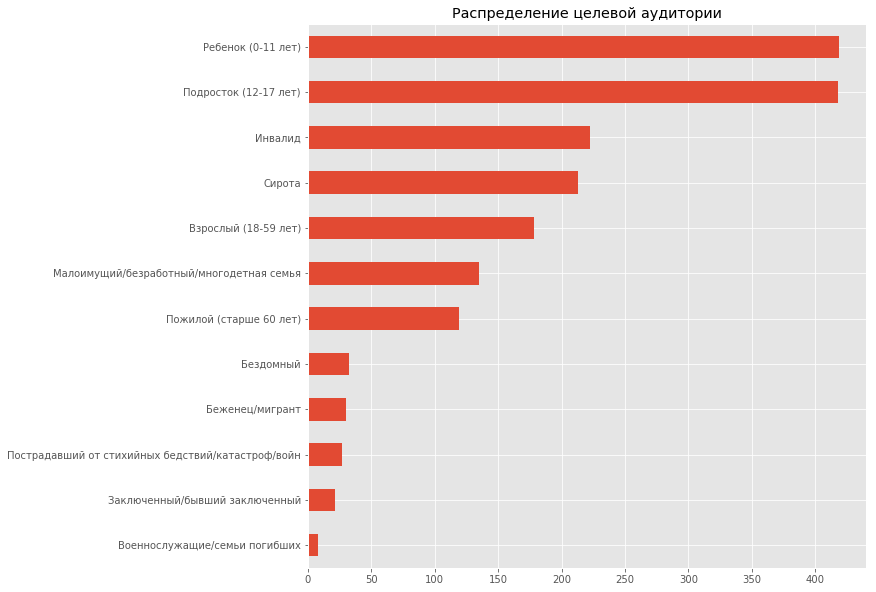

In [89]:
plt.figure(figsize=(10, 10))
audience_data.sum().sort_values().plot(kind="barh");
plt.title("Распределение целевой аудитории");

In [12]:
from mpl_toolkits.basemap import Basemap

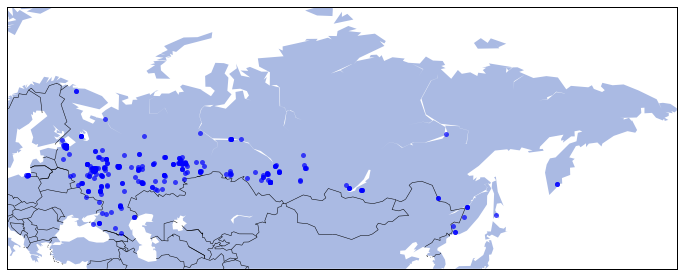

In [13]:
m = Basemap(projection='mill', llcrnrlat=35, urcrnrlat=80, llcrnrlon=15, urcrnrlon=190, resolution ="c") 

plt.figure(figsize=(12,10))
m.drawcountries()

m.fillcontinents(color="#AABAE3", lake_color="#FFFFFF")
m.drawmapboundary(fill_color="#FFFFFF")


lat = data.latitude.dropna().values
lon = data.longtitude.dropna().values
x,y = m(lon, lat)
m.plot(x,y, "bo", markersize=5, alpha = 0.7);